# Build  spectra for AuxTel with new spectractor (September 2021): Part 1

# For processing September 09 Planetary Nebula

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- cretion date : September 22th  2021
- version v3


**This notebook is to help for finding the position of order 0 of the target**

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and anaconda3_auxtel_v2 (no libradtran)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from iminuit import Minuit
import iminuit

In [3]:
iminuit.__version__

'2.7.0'

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [5]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [6]:
from astropy.visualization import simple_norm

In [7]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [8]:
from astroquery.simbad import Simbad
#import astropy.coordinates as coord

import astropy.units as u

In [9]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table

In [10]:
FLAG_REMOVE_WCS=False

# Path

In [11]:
HOSTCC=False

In [12]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/2021-09-09")
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/2021-09-09")

# Function

In [13]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [14]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

# Logbook for file selection

In [15]:
filename_logbook='logbooks/auxtelholologbook_PNG_2021_09_09_v2.0.csv'

In [16]:
df=pd.read_csv(filename_logbook,index_col=0)

In [17]:
pd.set_option('display.max_rows', None)

In [18]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-09-09T23:53:55.100,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000165_...,165,PNG321.0+03.9,empty_1,holo4_003,1.380357,10.0,...,9.2,16.0,4.0,300.0,1750.0,NaN,NaN,,1.0,1.0
1,1,2021-09-09T23:54:18.095,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000166_...,166,PNG321.0+03.9,empty_1,holo4_003,1.381613,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
2,2,2021-09-09T23:54:41.122,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000167_...,167,PNG321.0+03.9,empty_1,holo4_003,1.382874,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
3,3,2021-09-09T23:55:04.180,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000168_...,168,PNG321.0+03.9,empty_1,holo4_003,1.384148,30.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
4,4,2021-09-09T23:55:47.196,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000169_...,169,PNG321.0+03.9,empty_1,holo4_003,1.386523,30.0,...,9.0,17.0,3.1,300.0,1750.0,NaN,NaN,,1.0,1.0
5,5,2021-09-09T23:56:30.224,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000170_...,170,PNG321.0+03.9,empty_1,holo4_003,1.388908,30.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
6,6,2021-09-09T23:57:13.142,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000171_...,171,PNG321.0+03.9,empty_1,holo4_003,1.391300,60.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
7,7,2021-09-10T00:04:18.230,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000174_...,174,PNG321.0+03.9,empty_1,holo4_003,1.415803,0.0,...,8.9,15.0,3.7,300.0,1750.0,NaN,NaN,,1.0,1.0
8,8,2021-09-10T00:06:01.239,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000175_...,175,PNG321.0+03.9,empty_1,holo4_003,1.421962,60.0,...,8.9,15.0,3.8,300.0,1750.0,NaN,NaN,,1.0,1.0
9,9,2021-09-10T00:07:14.156,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000176_...,176,PNG321.0+03.9,empty_1,holo4_003,1.426365,60.0,...,8.9,15.0,4.4,300.0,1750.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [19]:
target_name="PNG321.0+03.9"

In [20]:
sky_coord_target=SkyCoord.from_name(target_name)
sky_coord_target

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [21]:
idx=10

In [22]:
myhome=os.getenv("HOME")

In [23]:
dir_images=path_images

In [24]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

In [25]:
file_target(filename_image)

'PNG321.0+03.9'

## Configuration file 

Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [26]:
filename=os.path.join(dir_images,filename_image)
output_directory="./outputs_process_holo_PNG"
output_figures="figures_process_holo_PNG"
guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)
# standard configuration
# config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY (dispersion rotation angle)
config="./config/auxtel_PNG.ini"

target = file_target(filename_image)[0]

In [27]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)

# Configuration of the running mode

In [28]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [29]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- adaptation to Spectractor (master branch) for Auxtel

In [30]:
from shutil import copyfile

In [31]:
copyfile(filename,filename_image)

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

In [32]:
from astropy.io import fits

In [33]:
hdu = fits.open(filename_image)

In [34]:
hdu.info()

Filename: holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [35]:
header=hdu[0].header
image=hdu[0].data

In [36]:
hdu.close()

## Rotate the image as expected by Spectractor

In [37]:
rot_image=np.flip(np.flip(image, 1), 0)
#rot_image=np.flip(image, 1)
#rot_image=image

In [38]:
# Create an ImageNormalize object
# norm = simple_norm(image, 'log')

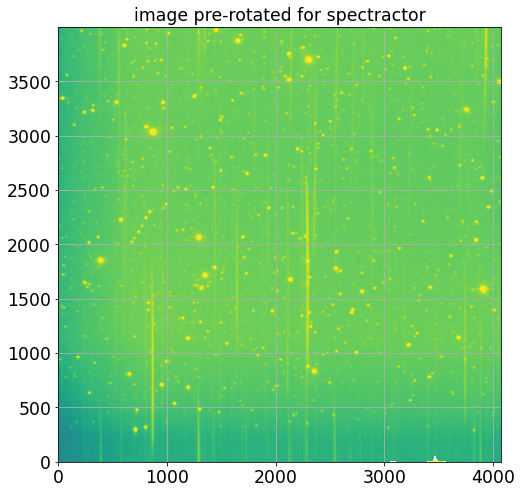

In [39]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.imshow(rot_image,origin="lower",norm=LogNorm(0.1,1000))
ax.grid()
ax.set_title("image pre-rotated for spectractor")
plt.show()

In [40]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-09-10T00:08:53.255'                                             
DATE-OBS= '2021-09-10T00:08:27.395'                                             
DATE-BEG= '2021-09-10T00:08:27.395'                                             
DATE-END= '2021-09-10T00:09:27.622'                                             
MJD     =     59467.0061719347                                                  
MJD-OBS =     59467.00587262

In [41]:
wcs = WCS(header)

Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-05 14:55:17  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


In [42]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 224.970833333333  -54.3019444444444  
CRPIX : 2000.0  2036.0  
CD1_1 CD1_2  : -0.0957509796129229  0.0430900209232442  
CD2_1 CD2_2  : -0.0430900209232442  -0.0957509796129229  
NAXIS : 4072  4000

### Remove WCS

In [43]:
if FLAG_REMOVE_WCS:
    del header['WCSAXES']
    del header['CTYPE1']
    del header['CTYPE2']
    del header['CUNIT1']
    del header['CUNIT2']
    del header['CRVAL1']
    del header['CRVAL2']
    del header['CRPIX1']
    del header['CRPIX2']
else:
    wcs = WCS(header)
    print(wcs)
    

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 224.970833333333  -54.3019444444444  
CRPIX : 2000.0  2036.0  
CD1_1 CD1_2  : -0.0957509796129229  0.0430900209232442  
CD2_1 CD2_2  : -0.0430900209232442  -0.0957509796129229  
NAXIS : 4072  4000


## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [44]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [45]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [46]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     123   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [47]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new file

In [48]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

/users/dagoret/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## Show relevant parameters

In [49]:
parameters.OBS_NAME

'AUXTEL'

In [50]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [51]:
parameters.DISTANCE2CCD

182.0

In [52]:
parameters.LAMBDA_MIN 

300

In [53]:
parameters.LAMBDA_MAX 

1100

In [54]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [55]:
image.filter_label

''

In [56]:
image.header["FILTER"]

'empty_1'

In [57]:
#image.header

# Plot image and find the target position

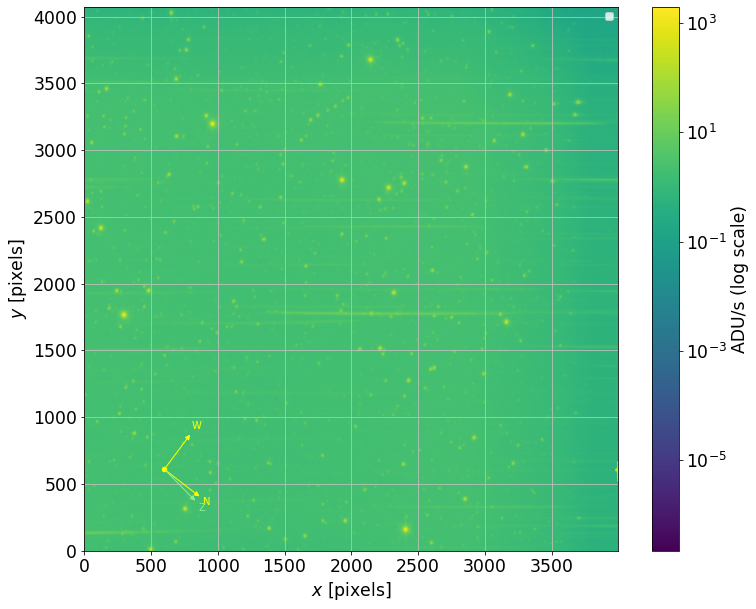

In [58]:
image.plot_image(figsize=(12, 10),scale="log")

In [59]:
filename_image

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

# Open image in astropy

In [60]:
sky_coord_target

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [61]:
hdu = fits.open(filename_image)

In [62]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-09-10T00:08:53.255'                                             
DATE-OBS= '2021-09-10T00:08:27.395'                                             
DATE-BEG= '2021-09-10T00:08:27.395'                                             
DATE-END= '2021-09-10T00:09:27.622'                                             
MJD     =     59467.0061719347                                                  
MJD-OBS =     59467.00587262

In [63]:
header=hdu[0].header
image=hdu[1].data

In [64]:
wcs = WCS(header)

2021-10-05 14:55:30  astroquery _showwarning         WARNING FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-05 14:55:30  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


In [65]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 224.970833333333  -54.3019444444444  
CRPIX : 2000.0  2036.0  
CD1_1 CD1_2  : -0.0957509796129229  0.0430900209232442  
CD2_1 CD2_2  : -0.0430900209232442  -0.0957509796129229  
NAXIS : 0  0


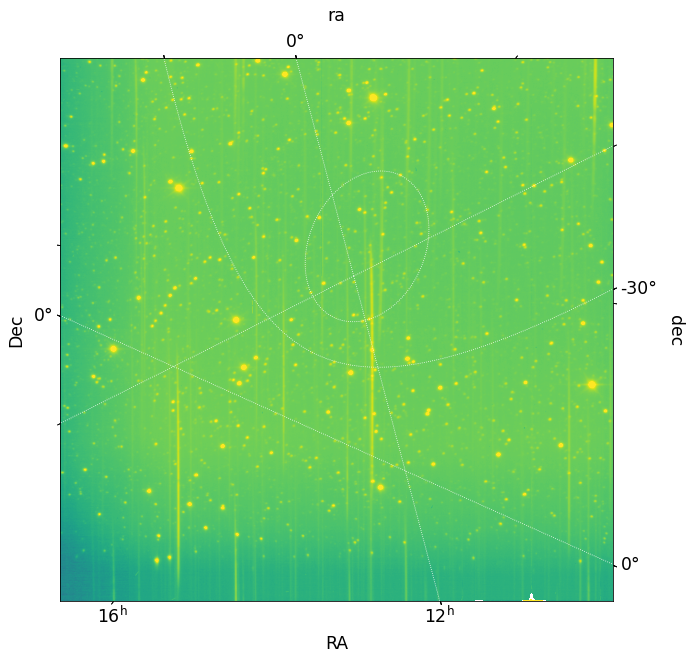

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
plt.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

# Remove temporary file

In [67]:
# os.remove(filename_image)

# Work with astrometry.net

In [68]:
FLAG_RESULTS_ASTROMETRY_NET=True
DIR_RESULT_ASTROMETRY_NET="astrometry_PNG"

In [69]:
file_new_image="new-image.fits" # New FITS image
file_axy="axy.fits"             # Stars detected in your images (x,y table) 
file_wcs="wcs.fits"             # WCS file
file_corr="corr.fits"           # Correspondences between image and reference stars
file_rdls="rdls.fits"           # Reference stars nearby (RA,Dec table):

In [70]:
fullfile_new_image=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_new_image)
fullfile_wcs=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_wcs)
fullfile_axy=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_axy)
fullfile_rdls=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_rdls)
fullfile_corr=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_corr)

## The astrometry.net image

In [71]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu = fits.open(fullfile_new_image)
    hdu.info()

Filename: astrometry_PNG/new-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     340   (4072, 4000)   float32   


In [72]:
if FLAG_RESULTS_ASTROMETRY_NET:
    header=hdu[0].header
    image=hdu[0].data
    wcs = WCS(header)
    print(wcs)
    

Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-05 14:55:32  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 224.939883519  -54.2545316342  
CRPIX : 1597.00780106  2219.8187561  
CD1_1 CD1_2  : 2.53628363851e-05  -7.99668590565e-06  
CD2_1 CD2_2  : 7.85817634212e-06  2.53799656385e-05  
NAXIS : 4072  4000


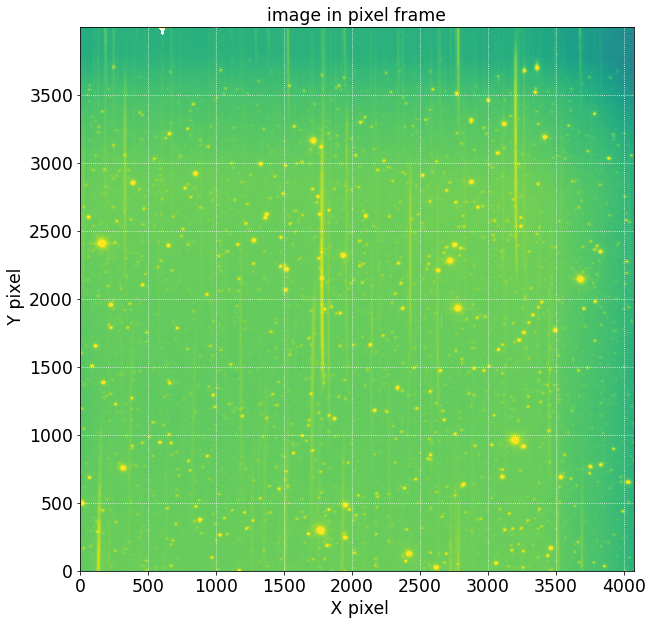

In [73]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.imshow(image, origin="lower",aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r' X pixel')
    ax.set_ylabel(r' Y pixel')


    ax.grid(color='white', ls='dotted')
    ax.set_title("image in pixel frame")

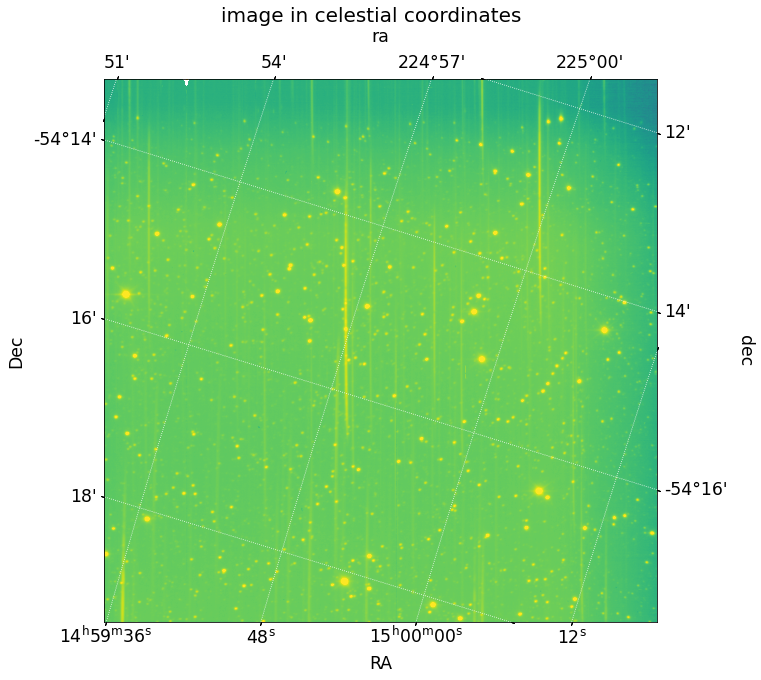

In [74]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)
    ax.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'Dec')

    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')
    
    plt.suptitle("image in celestial coordinates",fontsize=20)
    
    

## WCS coordinates

In [75]:
hdu_wcs = fits.open(fullfile_wcs)

In [76]:
hdu_wcs.info()

Filename: astrometry_PNG/wcs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     196   ()      


In [77]:
hdu = hdu_wcs[0]

In [78]:
wcs_astrometry = WCS(hdu.header)

2021-10-05 14:55:36  astroquery _showwarning         WARNING FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)


In [79]:
wcs_astrometry

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 224.939883519  -54.2545316342  
CRPIX : 1597.00780106  2219.8187561  
CD1_1 CD1_2  : 2.53628363851e-05  -7.99668590565e-06  
CD2_1 CD2_2  : 7.85817634212e-06  2.53799656385e-05  
NAXIS : 0  0

## Stars detected in your images (x,y table) 

In [80]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_axy = fits.open(fullfile_axy)
    hdu_axy.info()

Filename: astrometry_PNG/axy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1                1 BinTableHDU     16   1000R x 4C   [E, E, E, E]   


In [81]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_axy = Table.read(fullfile_axy, hdu=1)  

In [82]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_axy.show_in_notebook()
    print(t_axy)

    X         Y        FLUX    BACKGROUND
--------- --------- ---------- ----------
3197.3396  963.0529  100932.54  121.25781
161.49068 2408.8982   93516.83     127.75
1767.9879   299.531   78079.27  128.52344
3677.8813 2145.8545  51094.305   97.78125
  607.516 3992.2969  23386.354   37.31836
 316.9294  757.5716   22961.12  114.04883
 1713.533  3163.875  21775.436  106.44922
1933.4297 2320.1553  14011.275  129.58789
 3118.359 3287.2915   8512.671   95.76465
2776.4636 1932.2736   47116.79  128.48438
      ...       ...        ...        ...
244.91377  2792.307   35.11886  127.04098
 2414.281 1290.7682  132.36676 116.093994
2155.4492 1400.8196 127.128296  115.51929
3545.5635  1971.604  107.13559  110.57503
3456.1624 1132.7494 101.234055  109.80434
375.94327  783.1115  94.015495  113.72309
 702.7738 1708.0057  78.617035 110.740814
2084.9233 3083.8735  58.341667  111.09489
3676.3408 3981.8003   52.39053  18.944233
434.69662 3633.1646   46.64216   57.79677
1652.2367 205.66916  116.73689  12

##  Reference stars nearby (RA,Dec table):

In [83]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_rdls = fits.open(fullfile_rdls)
    hdu_rdls.info()

Filename: astrometry_PNG/rdls.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1                1 BinTableHDU     16   23R x 2C   [1D, 1D]   


In [84]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_rdls = Table.read(fullfile_rdls, hdu=1)  

In [85]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_rdls.show_in_notebook()
    print(t_rdls)

        RA                 DEC        
       deg                 deg        
------------------ -------------------
224.97560278700504  -54.30342775679245
224.99456389314219   -54.2032583471701
 224.9326722232136  -54.22992500374337
225.03138886899967  -54.23987224224005
 225.0269666891684 -54.274094441979244
224.88146665052255  -54.21948609698312
225.01346944306366 -54.302188891785626
224.90369445758802  -54.30163055966799
 225.0663139107267  -54.27504998161221
225.00359442820434  -54.30155831677307
               ...                 ...
 225.0339833249107 -54.233530575000906
224.98121942818952  -54.30195556281644
224.87868057035104  -54.24798610364541
 225.0540471945813  -54.27452500780796
  224.893902781191  -54.31072224254934
 224.8606388737141  -54.22741388820016
224.87458332551387 -54.261138904309774
224.99467777584852  -54.25262778155618
224.93554168131342 -54.255216658497424
224.95293608532316  -54.24944723763533
Length = 23 rows


In [86]:
NrefStars=len(t_rdls)

In [87]:
all_sep=np.zeros(NrefStars)
for idx in np.arange(NrefStars):
    the_ra=t_rdls[idx]['RA']
    the_dec=t_rdls[idx]['DEC']
    skyc=SkyCoord(ra=the_ra, dec=the_dec,frame='icrs',unit=(u.deg, u.deg))
    sep = sky_coord_target.separation(skyc).arcsec 
   
    all_sep[idx]=sep
    
    print(">>>>>>>>>>",the_ra,the_dec,sep)
    result_table = Simbad.query_region(skyc,radius=5./3600. * u.deg)
    if result_table != None :
        print(result_table)
    else:
        print("Reference star not found")
       

>>>>>>>>>> 224.97560278700504 -54.30342775679245 7.542358114837517


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


        MAIN_ID              RA         DEC     ... Z_VALUE SCRIPT_NUMBER_ID
                          "h:m:s"     "d:m:s"   ...                         
----------------------- ----------- ----------- ... ------- ----------------
2MASS J14595436-5418162 14 59 54.36 -54 18 16.2 ...      --                1
>>>>>>>>>> 224.99456389314219 -54.2032583471701 358.71642667511827


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:58.6953 -54:12:11.73': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.9326722232136 -54.22992500374337 273.17602334620216


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:43.8413 -54:13:47.73': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 225.03138886899967 -54.23987224224005 255.57579986329412


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:07.5333 -54:14:23.5401': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 225.0269666891684 -54.274094441979244 151.96911150990613


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:06.472 -54:16:26.74': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.88146665052255 -54.21948609698312 354.04374459423667


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:31.552 -54:13:10.1499': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 225.01346944306366 -54.302188891785626 85.35026119292459


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:03.2327 -54:18:07.88': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.90369445758802 -54.30163055966799 145.25851784349055


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:36.8867 -54:18:05.87': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 225.0663139107267 -54.27504998161221 219.21989583640647


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:15.9153 -54:16:30.1799': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 225.00359442820434 -54.30155831677307 64.63454256150757


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:00.8627 -54:18:05.6099': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.93491665079628 -54.21757222774282 314.5409499666897


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:44.38 -54:13:03.26': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.98759721268715 -54.241213879814914 221.33980539102964


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:57.0233 -54:14:28.37': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.95283056573973 -54.259861114436355 157.73370817970658


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:48.6793 -54:15:35.5': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 225.0339833249107 -54.233530575000906 278.2845104603824


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:08.156 -54:14:00.7101': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.98121942818952 -54.30195556281644 17.610598984646526


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


     MAIN_ID            RA           DEC      ... Z_VALUE SCRIPT_NUMBER_ID
                     "h:m:s"       "d:m:s"    ...                         
----------------- ------------- ------------- ... ------- ----------------
CCDM J14599-5418B 14 59 55.5392 -54 18 07.155 ...      --                1
>>>>>>>>>> 224.87868057035104 -54.24798610364541 277.6884400702097


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:30.8833 -54:14:52.75': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 225.0540471945813 -54.27452500780796 197.40210484590253


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:12.9713 -54:16:28.29': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.893902781191 -54.31072224254934 168.68674278617007


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:34.5367 -54:18:38.6001': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.8606388737141 -54.22741388820016 357.66444189876466


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:26.5533 -54:13:38.69': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.87458332551387 -54.261138904309774 253.72721019620104


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:29.9 -54:15:40.1001': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.99467777584852 -54.25262778155618 183.8860768856821


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:58.7227 -54:15:09.46': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.93554168131342 -54.255216658497424 186.06529516759343


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:44.53 -54:15:18.78': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 224.95293608532316 -54.24944723763533 194.07745343704488


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:48.7047 -54:14:58.0101': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found


In [88]:
all_sep

array([  7.54235811, 358.71642668, 273.17602335, 255.57579986,
       151.96911151, 354.04374459,  85.35026119, 145.25851784,
       219.21989584,  64.63454256, 314.54094997, 221.33980539,
       157.73370818, 278.28451046,  17.61059898, 277.68844007,
       197.40210485, 168.68674279, 357.6644419 , 253.7272102 ,
       183.88607689, 186.06529517, 194.07745344])

In [89]:
idx_target=np.where(all_sep==np.min(all_sep))[0][0]

## Correspondences between image and reference stars

In [90]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_corr = fits.open(fullfile_corr)
    hdu_corr.info()

Filename: astrometry_PNG/corr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     47   22R x 13C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1J, 1D, 1E, 1E]   


In [91]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_corr = Table.read(fullfile_corr, hdu=1)  

In [92]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_corr.show_in_notebook()
    print(t_corr)

     field_x            field_y       ...    FLUX   BACKGROUND
      pixels             pixels       ...                     
------------------ ------------------ ... --------- ----------
 3197.339599609375  963.0529174804688 ... 100932.54  121.25781
 161.4906768798828  2408.898193359375 ...  93516.83     127.75
  3677.88134765625    2145.8544921875 ... 51094.305   97.78125
 316.9294128417969  757.5715942382812 ...  22961.12  114.04883
 1713.532958984375           3163.875 ... 21775.436  106.44922
      1933.4296875    2320.1552734375 ... 14011.275  129.58789
 2776.463623046875 1932.2735595703125 ...  47116.79  128.48438
   2417.9541015625 127.08222961425781 ...  31647.55  126.42969
 15.19257926940918  500.0469665527344 ... 12639.384 112.325195
 1516.647216796875  2217.947998046875 ... 8103.4717  121.29785
 389.2887878417969  2854.364013671875 ...  7314.319  126.30322
 2617.345458984375  26.85270881652832 ... 12557.304  131.79395
  2752.89306640625  2398.425537109375 ...  9584.242  13

In [93]:
t_corr.show_in_notebook()

idx,field_x,field_y,field_ra,field_dec,index_x,index_y,index_ra,index_dec,index_id,field_id,match_weight,FLUX,BACKGROUND
,pixels,pixels,degrees,degrees,pixels,pixels,degrees,degrees,none,none,none,,
0,3197.339599609375,963.0529174804688,225.02649264728507,-54.27387612821937,3204.836089715402,952.1547262688391,225.0269666891684,-54.274094441979244,4,0,0.9960125164631518,100932.54,121.25781
1,161.4906768798828,2408.898193359375,224.8748744469465,-54.26098927362958,153.71279027867968,2405.4126512478306,224.87458332551387,-54.261138904309774,19,1,0.9952248974008244,93516.83,127.75
2,3677.88134765625,2145.8544921875,225.03096982975978,-54.240003953734096,3688.262868808139,2147.7955200349284,225.03138886899967,-54.23987224224005,3,3,0.9961003409213074,51094.305,97.78125
3,316.9294128417969,757.5715942382812,224.90349591851648,-54.301752390082235,322.36346419340316,760.679692201501,224.90369445758802,-54.30163055966799,7,5,0.99523281153234,22961.12,114.04883
4,1713.532958984375,3163.875,224.93184519141894,-54.22968562768355,1728.1498817041652,3149.87552380409,224.9326722232136,-54.22992500374337,2,6,0.9934182075277989,21775.436,106.44922
5,1933.4296875,2320.1552734375,224.95310031279752,-54.24934034521581,1928.773189200781,2317.385108055759,224.95293608532316,-54.24944723763533,22,7,0.9983241062968303,14011.275,129.58789
6,2776.463623046875,1932.2735595703125,224.99498000738268,-54.252547068466136,2769.2021892295206,1931.3444854366612,224.99467777584852,-54.25262778155618,20,9,0.9980183789943319,47116.79,128.48438
7,2417.9541015625,127.08222961425781,225.00369113828333,-54.30133529439965,2413.5382465054563,119.71610018423098,225.00359442820434,-54.30155831677307,9,10,0.9960031651737313,31647.55,126.42969
8,15.19257926940918,500.0469665527344,224.8935627616819,-54.31067543603439,21.830445083669247,496.1554281998226,224.893902781191,-54.31072224254934,17,12,0.9937971086185662,12639.384,112.325195


In [94]:
idx_target

0

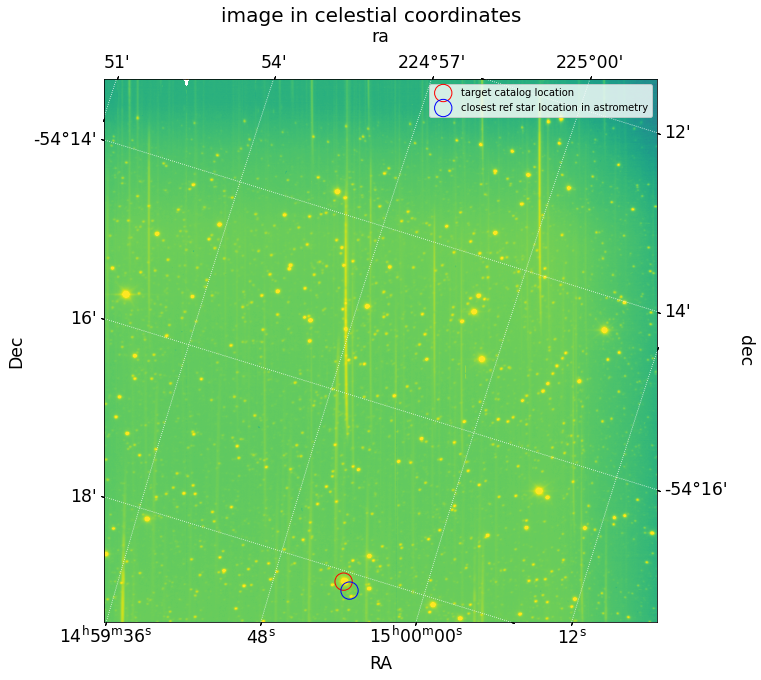

In [95]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)
    ax.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'Dec')

    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')

    ax.scatter(sky_coord_target.ra.deg,sky_coord_target.dec.deg, transform=ax.get_transform('icrs'), s=300,edgecolor='red', facecolor='none',label="target catalog location")
    ax.scatter(t_rdls[idx_target]["RA"],t_rdls[idx_target]["DEC"], transform=ax.get_transform('icrs'), s=300,edgecolor='blue', facecolor='none',label="closest ref star location in astrometry")

    ax.legend()
    
    plt.suptitle("image in celestial coordinates",fontsize=20)

In [96]:
NrefStars=len(t_corr)

NrefStars

22

In [97]:
all_sep=np.zeros(NrefStars)+9999
for idx in np.arange(NrefStars):
    
    the_ra=t_corr[idx]['field_ra']
    the_dec=t_corr[idx]['field_dec']
    skyc=SkyCoord(ra=the_ra, dec=the_dec,frame='icrs',unit=(u.deg, u.deg))
    sep = sky_coord_target.separation(skyc).arcsec 
   
    all_sep[idx]=sep
    
    print(">>>>>>>>>>",idx," ra=",the_ra," dec=",the_dec," sep=",sep)
    result_table = Simbad.query_region(skyc,radius=5./3600. * u.deg)
    if result_table != None :
        print(result_table)
    else:
        print("Reference star not found")
       

>>>>>>>>>> 0  ra= 225.02649264728507  dec= -54.27387612821937  sep= 151.75014160854593


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:06.3582 -54:16:25.9541': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 1  ra= 224.8748744469465  dec= -54.26098927362958  sep= 253.54377595680495


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:29.9699 -54:15:39.5614': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 2  ra= 225.03096982975978  dec= -54.240003953734096  sep= 254.73648771088654


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:07.4328 -54:14:24.0142': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 3  ra= 224.90349591851648  dec= -54.301752390082235  sep= 145.67101536973075


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:36.839 -54:18:06.3086': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 4  ra= 224.93184519141894  dec= -54.22968562768355  sep= 274.53669081006905


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:43.6428 -54:13:46.8683': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 5  ra= 224.95310031279752  dec= -54.24934034521581  sep= 194.3792712279149


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:48.7441 -54:14:57.6252': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 6  ra= 224.99498000738268  dec= -54.252547068466136  sep= 184.32683284429174


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:58.7952 -54:15:09.1694': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 7  ra= 225.00369113828333  dec= -54.30133529439965  sep= 64.86645888085292


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:00.8859 -54:18:04.8071': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 8  ra= 224.8935627616819  dec= -54.31067543603439  sep= 169.3580160614283


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:34.4551 -54:18:38.4316': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 9  ra= 224.93641974371698  dec= -54.25521052177655  sep= 185.31540926635856


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:44.7407 -54:15:18.7579': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 10  ra= 224.8787365776624  dec= -54.247913599305285  sep= 277.7878625303258


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:30.8968 -54:14:52.489': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 11  ra= 225.01371727578484  dec= -54.30232273333557  sep= 85.87406953312049


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:03.2921 -54:18:08.3618': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 12  ra= 224.9874870242735  dec= -54.240899867995566  sep= 222.42697495521793


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:56.9969 -54:14:27.2395': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 13  ra= 224.98160353532566  dec= -54.30199293002311  sep= 18.414121896778834


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


     MAIN_ID            RA           DEC      ... Z_VALUE SCRIPT_NUMBER_ID
                     "h:m:s"       "d:m:s"    ...                         
----------------- ------------- ------------- ... ------- ----------------
CCDM J14599-5418B 14 59 55.5392 -54 18 07.155 ...      --                1
>>>>>>>>>> 14  ra= 224.99502373402146  dec= -54.203112722950976  sep= 359.3607070207036


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:58.8057 -54:12:11.2058': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 15  ra= 225.0667843853774  dec= -54.27516411335444  sep= 219.92449019837082


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:16.0283 -54:16:30.5908': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 16  ra= 225.0344439324991  dec= -54.233675014153974  sep= 278.2727217080212


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:08.2665 -54:14:01.2301': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 17  ra= 225.0532050011984  dec= -54.27448012719988  sep= 195.95624313830308


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:00:12.7692 -54:16:28.1285': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 18  ra= 224.97658073908283  dec= -54.30450288728888  sep= 11.713744434168927


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


        MAIN_ID              RA         DEC     ... Z_VALUE SCRIPT_NUMBER_ID
                          "h:m:s"     "d:m:s"   ...                         
----------------------- ----------- ----------- ... ------- ----------------
2MASS J14595436-5418162 14 59 54.36 -54 18 16.2 ...      --                1
>>>>>>>>>> 19  ra= 224.86080777652361  dec= -54.227458653769254  sep= 357.30903078374917


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:26.5939 -54:13:38.8512': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 20  ra= 224.95260979681333  dec= -54.2604278171149  sep= 155.89419247610405


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:48.6264 -54:15:37.5401': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 21  ra= 224.93435052829  dec= -54.21793374431719  sep= 313.58722181773527


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:59:44.2441 -54:13:04.5615': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found


In [98]:
all_sep

array([151.75014161, 253.54377596, 254.73648771, 145.67101537,
       274.53669081, 194.37927123, 184.32683284,  64.86645888,
       169.35801606, 185.31540927, 277.78786253,  85.87406953,
       222.42697496,  18.4141219 , 359.36070702, 219.9244902 ,
       278.27272171, 195.95624314,  11.71374443, 357.30903078,
       155.89419248, 313.58722182])

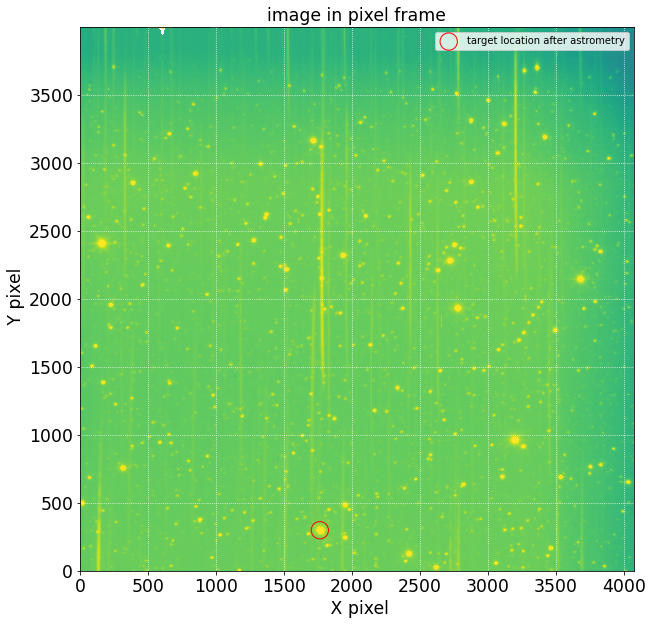

In [99]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.imshow(image, origin="lower",aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r' X pixel')
    ax.set_ylabel(r' Y pixel')

    x0, y0 = wcs.world_to_pixel(sky_coord_target)
    ax.scatter(x0,y0, s=300,edgecolor='red', facecolor='none',label="target location after astrometry")

    ax.grid(color='white', ls='dotted')
    ax.set_title("image in pixel frame")
    ax.legend()